# Summary
||||||||||||||||||||||||||||||||||||||||

IEEE Computational Intelligence Society · Research Prediction

Fraud Detection

|||||||||||||||||||||||||||||||||||||||||

# Packages

In [27]:
!pip install shap numba feature-engine ppscore

In [28]:
!pip install numba --upgrade

In [29]:
#  Manipulation & mathématiques
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency, spearmanr, skew, kurtosis

#  Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#  Modélisation statistique et VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#  Prétraitement
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder, LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#  Séparation et validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Modèles de classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

#  Métriques d'évaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, fbeta_score
)

# Visualisation avancée des modèles
import shap
from yellowbrick.regressor import ResidualsPlot

# Feature selection
from feature_engine.selection import DropFeatures

# PPS (Predictive Power Score)
import ppscore as pps

#  Système de fichiers
from pathlib import Path

#  Suppression des avertissements inutiles
import warnings
warnings.filterwarnings("ignore")


In [30]:
# Charger le chemin d'accès correspondant à votre machine 
HOME_DIR = r"C:\Users\HP\Desktop\LESLYE\ISEP2\S2\MACHINE_LEARNING\01-ieee-fraud-detection" #charger le chemin d'acces

## Data manipulation

In [31]:
plt.style.use('ggplot')  #Applique un style de graphique proche de ggplot2 (R).
%matplotlib inline
#Affiche les graphiques directement dans le notebook.

pd.set_option('display.max_rows', 500)   # Affiche jusqu'à 500 lignes
pd.set_option('display.max_columns', 500)  # Affiche jusqu'à 500 colonnes
pd.set_option('display.width', 1000)     # Largeur d'affichage


In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Data

In [33]:

print(f"Work directory: {HOME_DIR} ")


Work directory: C:\Users\HP\Desktop\LESLYE\ISEP2\S2\MACHINE_LEARNING\01-ieee-fraud-detection 


In [ ]:
data = pd.read_csv(f"{HOME_DIR}/0_data/data_clean.csv")

In [ ]:
# Séparation des features et de la cible
x = data.drop(columns='isFraud')
y = data['isFraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
'''
x_train = pd.read_csv(f"{HOME_DIR}/0_data/data_clean.csv")
x_test = pd.read_csv(f"{HOME_DIR}/0_data/x_test.csv")
y_test = pd.read_csv(f"{HOME_DIR}/0_data/y_test.csv")
y_train = pd.read_csv(f"{HOME_DIR}/0_data/y_train.csv")
'''

In [35]:
variables_num = df_clean.select_dtypes(include=['float64', 'int64']).columns.drop('isFraud')
# Inclure int32
import math
n_cols = 3
n_rows = math.ceil(len(variables_num) / n_cols)

plt.figure(figsize=(n_cols*6, n_rows*4))
for i, col in enumerate(variables_num):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x='isFraud', y=col, data=df_clean)
    plt.title(f'Boxplot {col} vs isFraud')
    plt.tight_layout()
    plt.show()


NameError: name 'df_clean' is not defined

In [ ]:
## Traitement de transactionAMT

# checking outliers in Amount values
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(x='TransactionAmt', data=df_clean)
plt.show()

In [ ]:
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler object
robust_scaler = RobustScaler()

# Fit and transform the data
X_robust_scaled = robust_scaler.fit_transform(df_clean[['TransactionAmt']])

# Create a new DataFrame with the scaled data
#df_clean = pd.concat([df_clean, pd.DataFrame(X_robust_scaled, columns=['TransactionAmt_scaled'])], axis=1)
#df_clean = df_clean.drop(columns=['TransactionAmt'])
#df_clean = df_clean.rename(columns={'TransactionAmt_scaled': 'TransactionAmt'})
df_scaled = pd.DataFrame(X_robust_scaled, columns=['TransactionAmt_scaled'])

In [ ]:
df_clean

In [ ]:
# new boxplot for `Amount` values
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(x='TransactionAmt', data=df_clean)
plt.show()

In [ ]:
# illegal transactions by amount
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x=(df_clean.TransactionAmt[df_clean.isFraud==1]), bins=50)
ax.set_title('Illegal Transactions by Amount')
plt.show()


In [ ]:
# legal transactions by amount
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x=(df_clean.TransactionAmt[df_clean.isFraud==0]), bins=50)
ax.set_title('legal Transactions by Amount')
plt.show()


In [ ]:
for col_name in variables_cat:
    counts = df_clean.groupby([col_name, 'isFraud']).size().unstack()

    fig = go.Figure(data=[
        go.Bar(name='Non-Fraud', x=counts.index, y=counts[0]),
        go.Bar(name='Fraud', x=counts.index, y=counts[1])
    ])

    fig.update_layout(barmode='stack', title=f'Relation entre {col_name} et isFraud')
    fig.show(renderer="colab")

## Feature engeneering

### Datetime

In [162]:
# Train et test

def recode_date(df):
    # Calcul du jour de la semaine (0=Dimanche, 1=Lundi, ..., 6=Samedi)
    df['weekday'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7).astype(int)

    # Calcul de l'heure (0-23)
    df['hour'] = np.floor(df['TransactionDT'] / 3600) % 24
    df['hour'] = df['hour'].astype(int)

    # Noms des jours en français
    days = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']

    # Ajout du nom du jour
    df['weekday_name'] = df['weekday'].map(lambda x: days[x])

    return df


In [164]:
# ------------application et visualisation-----------------

x_train = recode_date(x_train)

x_test = recode_date(x_test)

'''
# Visualiser les  jours
x_train.groupby('weekday_name')['isFraud'].sum().plot.bar(
    title='Nombre de fraudes par jour',
    xlabel='Jour',
    ylabel='Nombre de fraudes'
)
'''
#ne pas utiliser s'il y'a trop de barres de meme taille

"\n# Visualiser les  jours\nx_train.groupby('weekday_name')['isFraud'].sum().plot.bar(\n    title='Nombre de fraudes par jour',\n    xlabel='Jour',\n    ylabel='Nombre de fraudes'\n)\n"

In [166]:
def periode_journee(hour):
    if 0 <= hour <= 5:
        return 'Nuit'
    elif 6 <= hour <= 15:
        return 'Journée'
    elif 16 <= hour <= 23:
        return 'Soirée'
    else:
        return 'Inconnu'  # Cas hors plage 0-23
#supprimer hour apres
#autre methode 0-5 , 6-13, 14-17 h , 18 h -23h

In [168]:
x_train['periode_journee'] = x_train['hour'].apply(periode_journee)

x_test['periode_journee'] = x_test['hour'].apply(periode_journee)


In [171]:
x_train

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_12,weekday,hour,weekday_name,periode_journee
40809,1008491,100.000,R,6177,399.0,150.0,american express,150.0,credit,264.0,anonymous.com,1.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,1.0,609.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,NotFound,3,16,Mer,Soirée
285886,7008212,29.990,W,7900,345.0,150.0,mastercard,224.0,debit,143.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,undefined,3,2,Mer,Nuit
104256,2071522,107.950,W,11690,111.0,150.0,visa,226.0,credit,191.0,comcast.net,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,15.0,1.0,501.0,502.0,502.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,200.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,200.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,undefined,1,23,Lun,Soirée
507860,13299752,241.950,W,2616,327.0,150.0,discover,102.0,credit,330.0,NaN,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,177.0,177.0,177.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,undefined,5,22,Ven,Soirée
196382,4412283,117.000,W,13780,298.0,150.0,visa,226.0,debit,441.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,

# Modeling

In [24]:
x_train.head()

,PC1,PC2,PC3,PC4,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,id_01
0,-501.007871,-22.161451,18.308107,-65.059677,-1.378728,0.379783,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,-0.5,2.0,0.0,0.0,-0.090909,0.0,0.951562,0.017123,0.140333,0.0
1,-501.007910,-22.161561,18.308088,-65.059541,-0.079104,-0.475458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,-1.0,0.000000,0.000000,0.086279,0.0
2,-500.989445,-22.152352,18.295660,-65.051722,-1.148460,0.476900,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.090909,0.0,0.782813,0.573059,0.608108,0.0
3,-501.007917,-22.161557,18.308066,-65.059792,1.283733,2.113841,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.276562,0.202055,0.270270,0.0
4,-396.694514,-117.506426,-20.840183,11.496081,-0.641418,0.587454,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.000000,0.000000,0.086279,0.0


In [25]:
def report_with_fn(y_true, y_pred, beta=2):
    """
    Affiche le rapport de classification et le Fβ-score,
    tout en mettant l'accent sur les faux négatifs (FN).
    """
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Affichage des faux négatifs
    print(f" Faux négatifs (fraudes non détectées) : {fn}")
    
    # Rapport détaillé avec précision, recall et F1-score
    print(classification_report(y_true, y_pred, digits=4))
    
    # Calcul et affichage du Fβ-score
    print(f"F{beta}-score (β={beta}) : {fbeta_score(y_true, y_pred, beta=beta):.4f}")


## Dummy classifers

In [ ]:
# 1. Identifier les colonnes numériques et catégorielles
numerical_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns

# 2. Définir le prétraitement pour chaque type de colonne
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

# 3. Créer le préprocesseur
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [ ]:

# 1. Pipeline avec le même prétraitement que les autres modèles
pipe_dummy = Pipeline([
    ("preproc", preprocessor), 
    ("dummy", DummyClassifier(strategy="most_frequent"))  # ou "stratified"
])

# 2. Entraînement
pipe_dummy.fit(x_train, y_train)

# 3. Prédictions
y_pred_dummy = pipe_dummy.predict(x_test)
y_prob_dummy = pipe_dummy.predict_proba(x_test)[:, 1]

# 4. Rapport de classification
print(" Rapport de classification – Dummy Classifier")
print(classification_report(y_test, y_pred_dummy, digits=4))

# 5. AUC
auc_dummy = roc_auc_score(y_test, y_prob_dummy)
print(f" AUC – Dummy Classifier : {auc_dummy:.4f}")

# 6. Matrice de confusion
ConfusionMatrixDisplay.from_estimator(pipe_dummy, x_test, y_test, cmap="Blues")
plt.title(" Matrice de confusion – Dummy Classifier")
plt.show()

# 7. Courbe ROC
RocCurveDisplay.from_estimator(pipe_dummy, x_test, y_test)
plt.title(" Courbe ROC – Dummy Classifier")
plt.show()


## Naives Bayes (Gaussian)

In [18]:
# 1. Identifier les colonnes numériques et catégorielles
numerical_cols = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns

# 2. Définir le prétraitement pour chaque type de colonne
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

# 3. Créer le préprocesseur
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# 4. Pipeline complet
pipe_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nb', GaussianNB())
])

# 5. Entraîner le pipeline
pipe_nb.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['id_12_NotFound', 'id_12_undefined', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit',
       'card6_debit or credit', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'P_emaildomain', 'TransactionDT', 'TransactionAmt',
       'card1', 'card2',...d5', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'D15',
       'id_01', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['addr1'], dtype='object'))])),
                ('nb', GaussianNB())])

🔍 Seuil optimal Naive Bayes (F2) : 0.0096
⭐ F2-score max : 0.2106


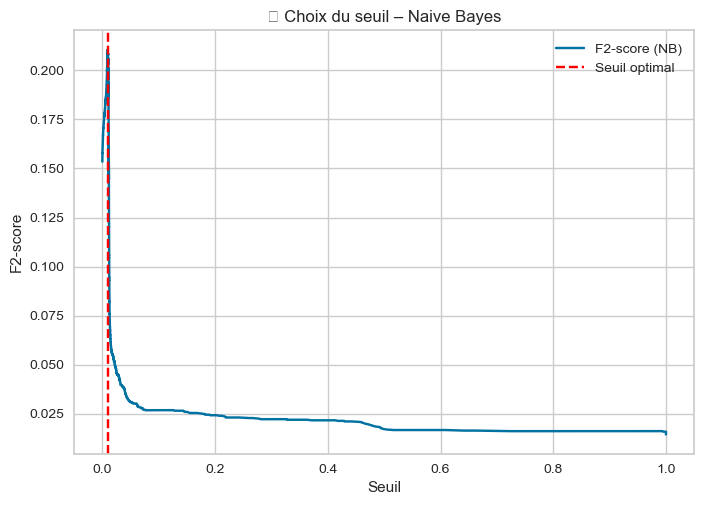

In [84]:

# === 1. Prédiction des probabilités sur les données de test ===
y_prob_nb = pipe_nb.predict_proba(x_test)[:, 1]  # Probabilité que y=1

# === 2. Calcul des courbes précision-rappel ===
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_test, y_prob_nb)

# === 3. Calcul du Fβ-score pour chaque seuil ===
beta = 2
f_beta_scores_nb = (1 + beta**2) * (precision_nb * recall_nb) / ((beta**2 * precision_nb) + recall_nb + 1e-6)

# === 4. Identification du meilleur seuil (celui qui maximise Fβ) ===
best_idx_nb = np.argmax(f_beta_scores_nb)
best_threshold_nb = thresholds_nb[best_idx_nb]

print(f"Seuil optimal Naive Bayes (F{beta}) : {best_threshold_nb:.4f}")
print(f"F{beta}-score max : {f_beta_scores_nb[best_idx_nb]:.4f}")

# === 5. Visualisation de l'évolution du Fβ-score selon le seuil ===
plt.plot(thresholds_nb, f_beta_scores_nb[:-1], label=f"F{beta}-score (NB)")
plt.axvline(x=best_threshold_nb, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil")
plt.ylabel(f"F{beta}-score")
plt.title("🎯 Choix du seuil – Naive Bayes")
plt.legend()
plt.show()



📋 Rapport de classification – Naive Bayes
              precision    recall  f1-score   support

           0     0.9774    0.6762    0.7994    113975
           1     0.0599    0.5686    0.1083      4133

    accuracy                         0.6725    118108
   macro avg     0.5186    0.6224    0.4539    118108
weighted avg     0.9453    0.6725    0.7752    118108

🔵 AUC – Naive Bayes : 0.6624


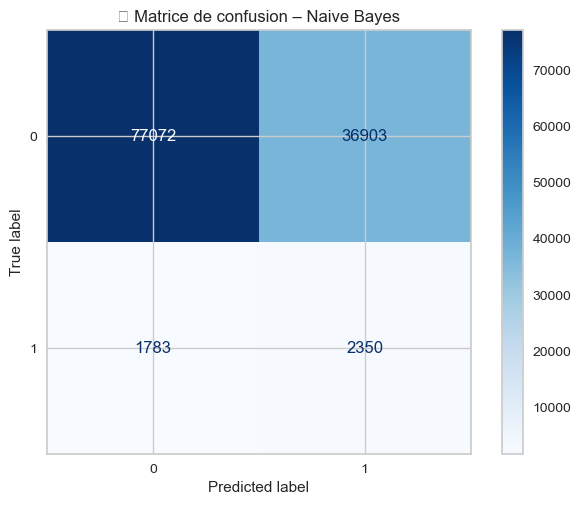

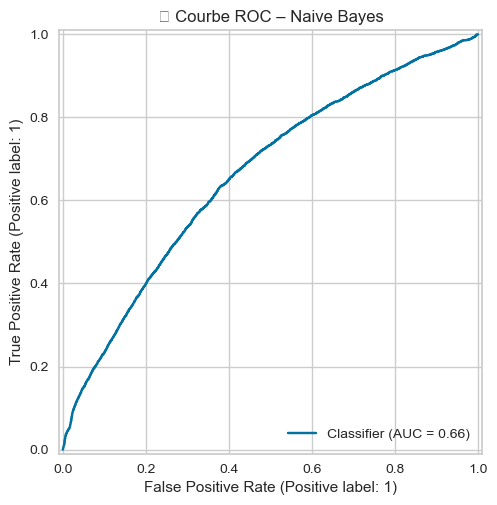

In [86]:
# === 6. Prédictions finales avec le seuil optimal ===
y_pred_nb = (y_prob_nb >= best_threshold_nb).astype(int)

# === 7. Rapport de classification (précision, rappel, f1, etc.) ===
print(" Rapport de classification – Naive Bayes")
print(classification_report(y_test, y_pred_nb, digits=4))

# === 8. Score AUC (area under ROC curve) ===
auc_nb = roc_auc_score(y_test, y_prob_nb)  # Attention : y_prob pour AUC, pas y_pred
print(f" AUC – Naive Bayes : {auc_nb:.4f}")

# === 9. Matrice de confusion ===
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, cmap="Blues")
plt.title(" Matrice de confusion – Naive Bayes")
plt.show()

# === 10. Courbe ROC ===
RocCurveDisplay.from_predictions(y_test, y_prob_nb)
plt.title(" Courbe ROC – Naive Bayes")
plt.show()

## Régression logistique

In [90]:
# Création du pipeline de modélisation pour la régression logistique
pipe_lr = Pipeline([
    ("preproc", preprocessor),  # Étape de prétraitement
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))  # Modèle avec pondération des classes
])

pipe_lr




Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['id_12_NotFound', 'id_12_undefined', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'card6_credit', 'card6_debit',
       'card6_debit or credit', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'P_emaildomain', 'TransactionDT', 'TransactionAmt',
       'card1', 'card2', 'card...
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'D15',
       'id_01', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['addr1'], dtype='object'))])),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [91]:
# Entraînement sur les données
pipe_lr.fit(x_train, y_train)

# Prédiction (seuil = 0.5 par défaut)
y_pred_lr_baseline = pipe_lr.predict(x_test)

# Évaluation baseline avant tuning
print(" Baseline – Logistic Regression (avant tuning, seuil = 0.5)")
report_with_fn(y_test, y_pred_lr_baseline, beta=2)

 Baseline – Logistic Regression (avant tuning, seuil = 0.5)
 Faux négatifs (fraudes non détectées) : 792
              precision    recall  f1-score   support

           0     0.9850    0.4558    0.6232    113975
           1     0.0511    0.8084    0.0961      4133

    accuracy                         0.4681    118108
   macro avg     0.5180    0.6321    0.3597    118108
weighted avg     0.9523    0.4681    0.6047    118108

F2-score (β=2) : 0.2040


In [99]:
# Définition simplifiée de la grille de recherche pour l'hyperparamètre C
param_grid_lr = {
    "lr__C": [0.1, 1] 
}

# Initialisation de la recherche avec validation croisée (CV) en optimisant l’AUC
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=3,      
    n_jobs=-1
)


In [101]:

# Entraînement du modèle avec recherche d'hyperparamètres
grid_lr.fit(x_train, y_train)

# Récupération du meilleur modèle
best_lr = grid_lr.best_estimator_

# Affichage de la meilleure AUC obtenue en validation croisée
print(f"Meilleure AUC (CV) : {grid_lr.best_score_:.4f}")


Meilleure AUC (CV) : 0.7086


In [102]:
# Définition simplifiée de la grille de recherche pour l'hyperparamètre C
param_grid_lr = {
    "lr__C": [0.1, 1]  # Plage réduite pour la régularisation
}

# Initialisation de la recherche avec validation croisée (CV) en optimisant l’AUC
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=3,       # CV réduite à 3 pour accélérer
    n_jobs=-1
)



In [107]:
# Prédiction des probabilités de fraude sur l'ensemble de validation
y_probs = best_lr.predict_proba(x_test)[:, 1]

# Calcul des courbes precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Choix d'un Fβ-score avec β > 1 pour pénaliser les faux négatifs
beta = 2

# Calcul du Fβ-score pour chaque seuil possible
f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-6)

# Détermination du meilleur seuil (celui maximisant le Fβ-score)
best_idx = np.argmax(f_beta_scores)
best_threshold = thresholds[best_idx]




 Seuil optimal (max F2-score) : 0.5693
F2-score max : 0.2158


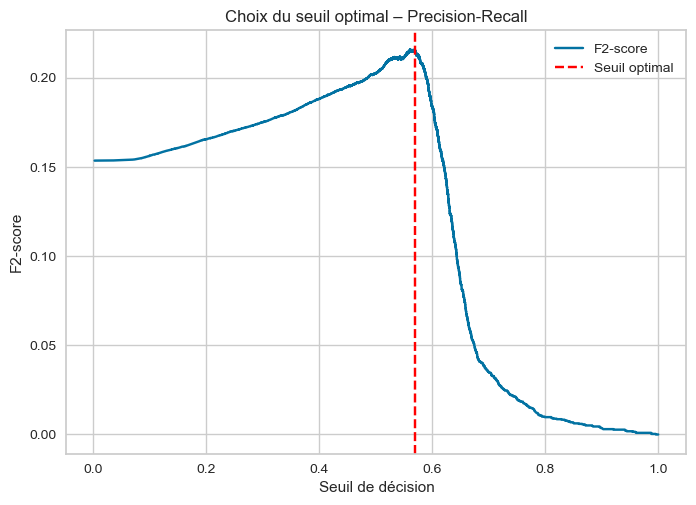

In [109]:
# Affichage des résultats
print(f" Seuil optimal (max F{beta}-score) : {best_threshold:.4f}")
print(f"F{beta}-score max : {f_beta_scores[best_idx]:.4f}")

# Visualisation du Fβ-score en fonction du seuil
plt.plot(thresholds, f_beta_scores[:-1], label=f"F{beta}-score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil de décision")
plt.ylabel(f"F{beta}-score")
plt.title("Choix du seuil optimal – Precision-Recall")
plt.legend()
plt.show()


 Rapport de classification – Régression Logistique
              precision    recall  f1-score   support

           0     0.9766    0.7292    0.8349    113975
           1     0.0648    0.5173    0.1151      4133

    accuracy                         0.7217    118108
   macro avg     0.5207    0.6232    0.4750    118108
weighted avg     0.9447    0.7217    0.8097    118108

AUC – Régression Logistique : 0.6843


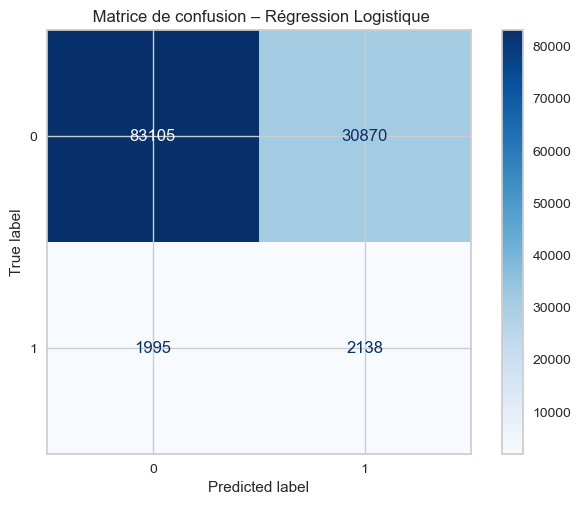

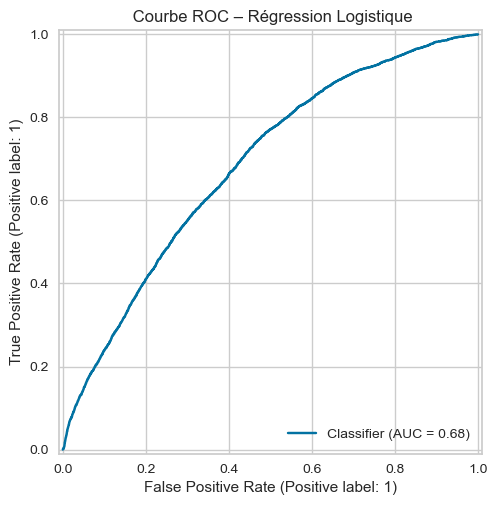

In [111]:
# Prédiction finale selon le seuil optimal
y_pred_lr = (y_probs >= best_threshold).astype(int)

# Rapport de classification
print(" Rapport de classification – Régression Logistique")
print(classification_report(y_test, y_pred_lr, digits=4))

#  Score 
auc_lr = roc_auc_score(y_test, y_probs)
print(f"AUC – Régression Logistique : {auc_lr:.4f}")

#  Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues")
plt.title(" Matrice de confusion – Régression Logistique")
plt.show()

# 📈 Courbe ROC
RocCurveDisplay.from_predictions(y_test, y_probs)
plt.title(" Courbe ROC – Régression Logistique")
plt.show()


In [ ]:
# ----------------------------
#  Importations nécessaires
# ----------------------------
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# -----------------------------------------------
# 1️ Pipeline Logistic Regression avec SMOTE
# -----------------------------------------------

pipe_lr_smote = ImbPipeline([
    ("preproc", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# ------------------------------------------
# 2️ Grille de recherche (SMOTE uniquement)
# ------------------------------------------
param_dist_smote_lr = {
    "smote__k_neighbors": [3, 5, 7],
    "smote__sampling_strategy": [0.5, 0.8, 1.0]
}

# --------------------------------------------------
# 3 RandomizedSearchCV (sur SMOTE uniquement)
# --------------------------------------------------
random_search_smote_lr = RandomizedSearchCV(
    estimator=pipe_lr_smote,
    param_distributions=param_dist_smote_lr,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# --------------------------
# 4️ Entraînement du modèle
# --------------------------
random_search_smote_lr.fit(x_train, y_train)

best_lr_smote_model = random_search_smote_lr.best_estimator_
print(" Meilleurs paramètres SMOTE trouvés :", random_search_smote_lr.best_params_)

# ------------------------------------------
# 5️ Prédiction proba + optimisation du seuil
# ------------------------------------------
y_prob_lr_smote = best_lr_smote_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lr_smote)

# F2-score
beta = 2
f2_scores = (1 + beta**2) * precision * recall / ((beta**2 * precision) + recall + 1e-6)

# Meilleur seuil
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

print(f"\n Seuil optimal avec SMOTE : {best_threshold:.4f}")
print(f" F{beta}-score optimal à ce seuil : {f2_scores[best_idx]:.4f}")

# ---------------------------
# 6️ Prédictions finales + évaluation
# ---------------------------
y_pred_lr_final = (y_prob_lr_smote >= best_threshold).astype(int)

print("\n📊 Évaluation finale – Régression Logistique avec SMOTE (seuil optimal)")
report_with_fn(y_test, y_pred_lr_final, beta=2)

# -----------------------------
# 7️⃣ Matrice de confusion + ROC
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred_lr_final)
print("Matrice de confusion – Régression Logistique avec SMOTE :")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion – Logistic Regression + SMOTE")
plt.show()

# AUC
auc_smote_lr = roc_auc_score(y_test, y_prob_lr_smote)
print(f"AUC – Régression Logistique avec SMOTE : {auc_smote_lr:.4f}")

# -----------------------------
#  ROC Curve – Logistic Regression + SMOTE
# -----------------------------
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs)  # y_probs déjà défini avant
auc_lr_smote = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression + SMOTE (AUC = {auc_lr_smote:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Faux positifs')
plt.ylabel('Vrais positifs')
plt.title('Courbe ROC – Logistic Regression + SMOTE')
plt.legend()
plt.grid()
plt.show()


Fitting 3 folds for each of 5 candidates, totalling 15 fits


## KNN

In [46]:
# Pipeline KNN sans tuning
pipe_knn_baseline = Pipeline([
    ("preproc", preprocessor),  # Prétraitement (scaling + one-hot)
    ("knn", KNeighborsClassifier())  # Modèle KNN avec paramètres par défaut
])

# Entraînement
pipe_knn_baseline.fit(x_train, y_train)

# Prédictions
y_pred_baseline = pipe_knn_baseline.predict(x_test) 

# Évaluation baseline
print("Évaluation baseline – KNN (par défaut)")
report_with_fn(y_test, y_pred_baseline, beta=2)


Évaluation baseline – KNN (par défaut)
 Faux négatifs (fraudes non détectées) : 3773
              precision    recall  f1-score   support

           0     0.9678    0.9958    0.9816    113975
           1     0.4281    0.0871    0.1448      4133

    accuracy                         0.9640    118108
   macro avg     0.6979    0.5414    0.5632    118108
weighted avg     0.9489    0.9640    0.9523    118108

F2-score (β=2) : 0.1036


In [ ]:
# Pipeline avec KNN
pipe_knn = Pipeline([
    ("preproc", preprocessor),
    ("knn", KNeighborsClassifier())
])

pipe_knn




# Grille d'hyperparamètres
param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__weights": ["uniform", "distance"]
}

# GridSearch avec AUC comme critère
grid_knn = GridSearchCV(
    pipe_knn, param_grid=param_grid_knn,
    scoring="roc_auc", cv=5, n_jobs=-1
)
grid_knn.fit(x_train, y_train)

# Meilleur modèle après tuning
best_knn = grid_knn.best_estimator_
print(f" Meilleure AUC (CV) KNN : {grid_knn.best_score_:.4f}")

# Évaluation post-tuning (seuil 0.5)
y_pred_knn_post_tuning = best_knn.predict(x_test)
print("Évaluation post-tuning – KNN (seuil 0.5)")
report_with_fn(y_test, y_pred_knn_post_tuning, beta=2)


In [ ]:
# Probabilités prédites
y_prob_knn = best_knn.predict_proba(X_val)[:, 1]

# Courbe precision-recall
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_val, y_prob_knn)

# Calcul du Fβ-score pour chaque seuil
beta = 2  # Accent sur le recall
f_beta_scores_knn = (1 + beta**2) * (precision_knn * recall_knn) / ((beta**2 * precision_knn) + recall_knn + 1e-6)

# Meilleur seuil
best_idx_knn = np.argmax(f_beta_scores_knn)
best_threshold_knn = thresholds_knn[best_idx_knn]
print(f"Seuil optimal KNN (F{beta}-score) : {best_threshold_knn:.4f}")
print(f"F{beta}-score max : {f_beta_scores_knn[best_idx_knn]:.4f}")

# Visualisation du F-score selon le seuil
plt.plot(thresholds_knn, f_beta_scores_knn[:-1], label=f"F{beta}-score (KNN)")
plt.axvline(x=best_threshold_knn, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil")
plt.ylabel(f"F{beta}-score")
plt.title("F-score – KNN (courbe Precision-Recall)")
plt.legend()
plt.show()

# Prédiction finale avec le seuil optimal
y_pred_knn_final = (y_prob_knn >= best_threshold_knn).astype(int)
print(" Évaluation finale – KNN (seuil optimal)")
report_with_fn(y_val, y_pred_knn_final, beta=2)


In [ ]:
#  AUC
auc_knn = roc_auc_score(y_val, y_prob_knn)
print(f"AUC – KNN : {auc_knn:.4f}")

# Courbe ROC
fpr_knn, tpr_knn, _ = roc_curve(y_val, y_prob_knn)
plt.plot(fpr_knn, tpr_knn, label=f"AUC = {auc_knn:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – KNN")
plt.legend()
plt.grid()
plt.show()

#  Matrice de confusion
cm_knn = confusion_matrix(y_val, y_pred_knn_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion – KNN (seuil optimal)")
plt.show()


## Random Forest 

In [113]:

# Étape 1 – Pipeline de base avec Random Forest par défaut
pipe_rf_baseline = Pipeline([
    ("preproc", preprocessor),  # Prétraitement : StandardScaler + OneHotEncoder
    ("rf", RandomForestClassifier(random_state=42))  # Modèle avec paramètres par défaut
])

# Entraînement du modèle baseline
pipe_rf_baseline.fit(x_train, y_train)

# Prédictions sur l’échantillon de validation
y_pred_rf_baseline = pipe_rf_baseline.predict(x_test)

# Évaluation avec un F-score mettant l'accent sur le recall (beta > 1)
print(" Évaluation baseline – Random Forest (params par défaut, seuil 0.5)")
report_with_fn(y_test, y_pred_rf_baseline, beta=2)


🔹 Évaluation baseline – Random Forest (params par défaut, seuil 0.5)
 Faux négatifs (fraudes non détectées) : 2061
              precision    recall  f1-score   support

           0     0.9822    0.9991    0.9906    113975
           1     0.9509    0.5013    0.6565      4133

    accuracy                         0.9816    118108
   macro avg     0.9666    0.7502    0.8235    118108
weighted avg     0.9811    0.9816    0.9789    118108

F2-score (β=2) : 0.5537


In [114]:
# Pipeline Random Forest
pipe_rf = Pipeline([
    ("preproc", preprocessor),
    ("rf", RandomForestClassifier(random_state=42))
])
pipe_rf





# Grille  des hyperparamètres
param_grid_rf = {
    "rf__n_estimators": [100],        
    "rf__max_depth": [10, None],      
    "rf__min_samples_split": [2],     # Valeur par défaut
    "rf__min_samples_leaf": [1, 2]    # Taille minimale des feuilles
}

# GridSearch avec validation croisée
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=3,              
    n_jobs=-1,
    verbose=1
)


In [115]:

# Entraînement du grid search
grid_rf.fit(x_train, y_train)

# Meilleur pipeline entraîné
best_rf = grid_rf.best_estimator_

# Évaluation sur validation, avec seuil 0.5
y_pred_rf_post_tuning = best_rf.predict(x_test)

# Affichage des performances
print(f" Meilleure AUC (CV) – Random Forest : {grid_rf.best_score_:.4f}")
print(" Évaluation post-tuning – Random Forest (seuil 0.5)")
report_with_fn(y_test, y_pred_rf_post_tuning, beta=2)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Meilleure AUC (CV) – Random Forest : 0.9394
 Évaluation post-tuning – Random Forest (seuil 0.5)
 Faux négatifs (fraudes non détectées) : 2478
              precision    recall  f1-score   support

           0     0.9787    0.9993    0.9889    113975
           1     0.9561    0.4004    0.5645      4133

    accuracy                         0.9784    118108
   macro avg     0.9674    0.6999    0.7767    118108
weighted avg     0.9779    0.9784    0.9741    118108

F2-score (β=2) : 0.4531


In [116]:
# Prédictions de probabilités (proba d'appartenir à la classe positive)
y_prob_rf = best_rf.predict_proba(x_test)[:, 1]

# Génération de la courbe Precision-Recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_prob_rf)

# Calcul du Fβ-score pour chaque seuil
beta = 2  # Accent mis sur le rappel
f_beta_scores_rf = (1 + beta**2) * (precision_rf * recall_rf) / ((beta**2 * precision_rf) + recall_rf + 1e-6)

# Recherche du seuil qui maximise le Fβ-score
best_idx_rf = np.argmax(f_beta_scores_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]

# Affichage du seuil optimal et du score associé
print(f" Seuil optimal – Random Forest : {best_threshold_rf:.4f}")
print(f"F{beta}-score max à ce seuil : {f_beta_scores_rf[best_idx_rf]:.4f}")


 Seuil optimal – Random Forest : 0.1395
F2-score max à ce seuil : 0.7122


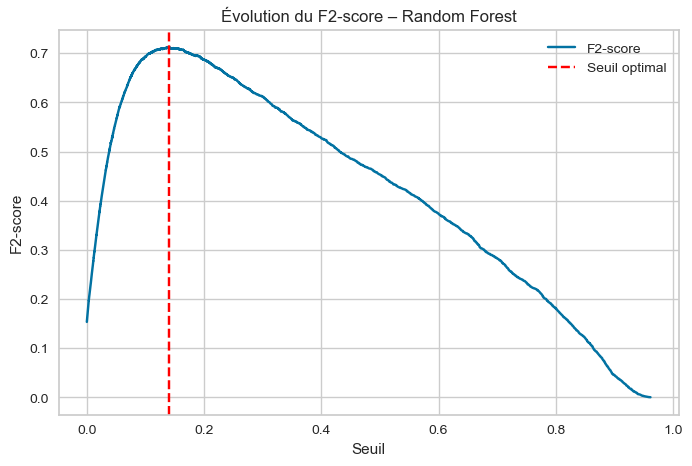

In [117]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds_rf, f_beta_scores_rf[:-1], label=f"F{beta}-score")
plt.axvline(x=best_threshold_rf, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil")
plt.ylabel(f"F{beta}-score")
plt.title(f"Évolution du F{beta}-score – Random Forest")
plt.legend()
plt.grid(True)
plt.show()


In [118]:
# Conversion des probabilités en classes selon le seuil optimal
y_pred_rf_final = (y_prob_rf >= best_threshold_rf).astype(int)

# Évaluation complète avec le Fβ-score
print("Évaluation finale – Random Forest (seuil optimal)")
report_with_fn(y_test, y_pred_rf_final, beta=2)


Évaluation finale – Random Forest (seuil optimal)
 Faux négatifs (fraudes non détectées) : 1048
              precision    recall  f1-score   support

           0     0.9907    0.9821    0.9864    113975
           1     0.6018    0.7464    0.6664      4133

    accuracy                         0.9738    118108
   macro avg     0.7963    0.8643    0.8264    118108
weighted avg     0.9771    0.9738    0.9752    118108

F2-score (β=2) : 0.7122


In [135]:
print("Best params:", grid_rf.best_params_)

Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


AUC – Random Forest : 0.9498


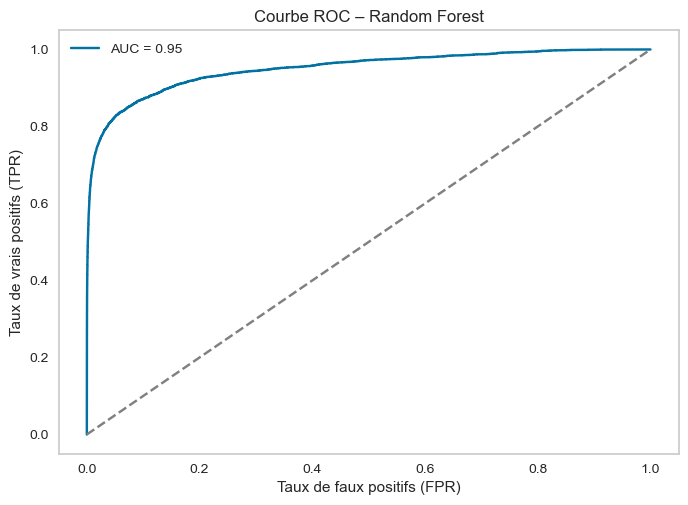

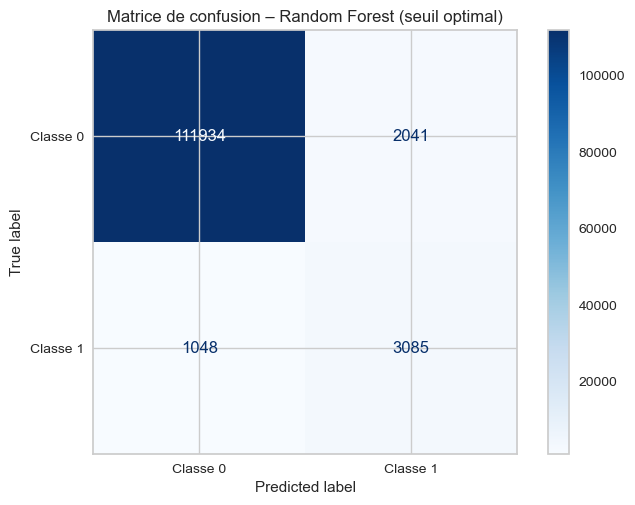

In [119]:

#  AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"AUC – Random Forest : {auc_rf:.4f}")

#  Courbe ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"AUC = {auc_rf:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC – Random Forest")
plt.legend()
plt.grid()
plt.show()

#  Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Classe 0", "Classe 1"])
disp.plot(cmap="Blues")
plt.title("Matrice de confusion – Random Forest (seuil optimal)")
plt.show()


In [139]:

# ----------------------------
#  Importations nécessaires
# ----------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV



# ----------------------------------------
# 1️ Pipeline Random Forest (avec SMOTE)
# ----------------------------------------

# On fixe les meilleurs hyperparamètres déjà trouvés pour RF 
best_params_rf = {
    "n_estimators": 100,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 2
}


pipe_rf_smote = ImbPipeline(steps=[
    ('preprocess', preprocessor),       
    ('smote', SMOTE(random_state=42)), 
    ('rf', RandomForestClassifier(random_state=42)) 
])
# -----------------------------------------------
# 2️ Définition de la grille de recherche SMOTE
# -----------------------------------------------
param_dist_smote = {
    "smote__k_neighbors": [3, 5, 7],             
    "smote__sampling_strategy": [0.5, 0.8, 1.0]  
}

# --------------------------------------------------
# 3️ RandomizedSearch sur SMOTE uniquement (fix RF)
# --------------------------------------------------
random_search_smote_rf = RandomizedSearchCV(
    estimator=pipe_rf_smote,
    param_distributions=param_dist_smote,
    n_iter=5,               
    scoring="roc_auc",       
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# -----------------------------
# 4️ Entraînement du modèle
# -----------------------------
random_search_smote_rf.fit(x_train, y_train)

# Récupération du meilleur pipeline entraîné
best_rf_smote_model = random_search_smote_rf.best_estimator_
print(" Meilleurs paramètres SMOTE trouvés :", random_search_smote_rf.best_params_)

# ---------------------------------------
# 5️ Prédictions probabilistes sur test
# ---------------------------------------
y_prob_rf_smote = best_rf_smote_model.predict_proba(x_test)[:, 1]

# -------------------------------------------------------------
# 6️ Optimisation du seuil avec F2-score (β=2 pour le rappel)
# -------------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_smote)
beta = 2
f2_scores = (1 + beta**2) * precision * recall / ((beta**2 * precision) + recall + 1e-6)

# Meilleur seuil basé sur le F2
best_threshold = thresholds[np.argmax(f2_scores)]
print(f"\n Seuil optimal avec SMOTE : {best_threshold:.4f}")
print(f" F{beta}-score optimal à ce seuil : {np.max(f2_scores):.4f}")

# --------------------------------------------------------
# 7️ Prédiction finale avec ce seuil et évaluation finale
# --------------------------------------------------------
y_pred_rf_final = (y_prob_rf_smote >= best_threshold).astype(int)

print("\n Évaluation finale – Random Forest avec SMOTE (seuil optimal)")
report_with_fn(y_test, y_pred_rf_final, beta=2)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Meilleurs paramètres SMOTE trouvés : {'smote__sampling_strategy': 0.5, 'smote__k_neighbors': 3}

📌 Seuil optimal avec SMOTE : 0.2300
🔹 F2-score optimal à ce seuil : 0.7384

📊 Évaluation finale – Random Forest avec SMOTE (seuil optimal)
 Faux négatifs (fraudes non détectées) : 1031
              precision    recall  f1-score   support

           0     0.9909    0.9880    0.9894    113975
           1     0.6935    0.7505    0.7209      4133

    accuracy                         0.9797    118108
   macro avg     0.8422    0.8693    0.8552    118108
weighted avg     0.9805    0.9797    0.9800    118108

F2-score (β=2) : 0.7384



🎯 AUC – Random Forest avec SMOTE : 0.9402


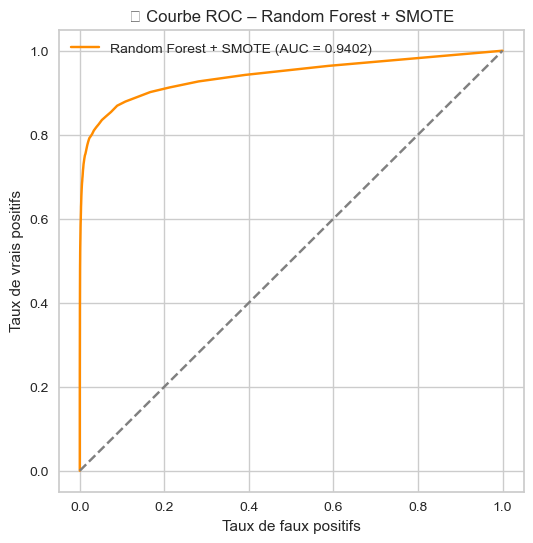

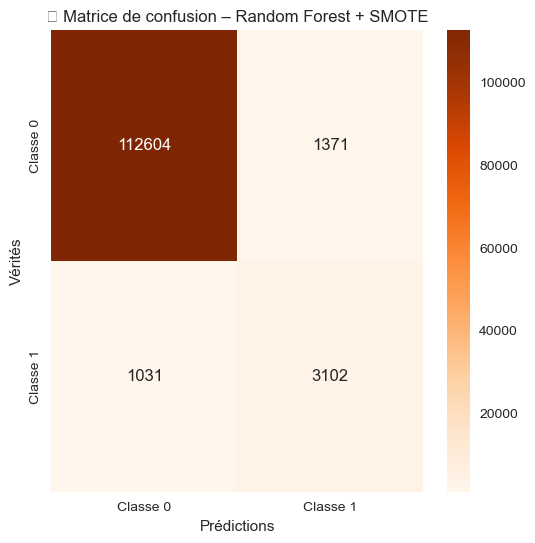

In [143]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 8️ AUC – Random Forest + SMOTE
# --------------------------
auc_rf_smote = roc_auc_score(y_test, y_prob_rf_smote)
print(f"\n AUC – Random Forest avec SMOTE : {auc_rf_smote:.4f}")

# --------------------------
#  Courbe ROC – RF + SMOTE
# --------------------------
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_smote)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest + SMOTE (AUC = {auc_rf_smote:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title(' Courbe ROC – Random Forest + SMOTE')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
#  Matrice de confusion – RF + SMOTE
# --------------------------
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf_final)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title(' Matrice de confusion – Random Forest + SMOTE')
plt.show()



## Lightgbm

In [32]:
# Pipeline LightGBM baseline (sans tuning)
pipe_lgb_baseline = Pipeline([
    ("preproc", preprocessor),
    ("lgb", LGBMClassifier(random_state=42))
])

# Entraînement
pipe_lgb_baseline.fit(x_train, y_train)

# Prédiction sur validation
y_pred_lgb_baseline = pipe_lgb_baseline.predict(x_test)

# Évaluation baseline
print(" Évaluation baseline – LightGBM (params par défaut, seuil 0.5)")
report_with_fn(y_test, y_pred_lgb_baseline, beta=2)


[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6458
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
 Évaluation baseline – LightGBM (params par défaut, seuil 0.5)
 Faux négatifs (fraudes non détectées) : 2418
              precision    recall  f1-score   support

           0     0.9792    0.9980    0.9885    113975
           1     0.8822    0.4150    0.5644      4133

    accuracy                         0.9776    118108
   macro avg     0.9307    0.7065    0.7765    118108
weighted avg     0.9758    0.9776    0.9737    118108

F2-

In [36]:
# Pipeline pour tuning LightGBM
pipe_lgb = Pipeline([
    ("preproc", preprocessor),
    ("lgb", LGBMClassifier(random_state=42))
])
pipe_lgb






# Grille  de paramètres 
param_grid_lgb = {
    "lgb__n_estimators": [100, 200],
    "lgb__max_depth": [-1, 10, 20],
    "lgb__learning_rate": [0.1, 0.05],
    "lgb__num_leaves": [31, 64]
}

# GridSearch avec AUC
grid_lgb = GridSearchCV(
    pipe_lgb, param_grid=param_grid_lgb,
    scoring="roc_auc", cv=5, n_jobs=-1, verbose=1
)

# Fit
grid_lgb.fit(x_train, y_train)

# Meilleur modèle
best_lgb = grid_lgb.best_estimator_

# Prédiction avec seuil par défaut
y_pred_lgb_post_tuning = best_lgb.predict(x_test)

# Résultats
print(f" Meilleure AUC (CV) – LightGBM : {grid_lgb.best_score_:.4f}")
print(" Évaluation post-tuning – LightGBM (seuil 0.5)")
report_with_fn(y_test, y_pred_lgb_post_tuning, beta=2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6458
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
 Meilleure AUC (CV) – LightGBM : 0.9483
 Évaluation post-tuning – LightGBM (seuil 0.5)
 Faux négatifs (fraudes non détectées) : 1993
              precision    recall  f1-score   support

           0     0.9828    0.9982    0.9904    113975
           1     0.9134    0.5178    0.6609      4133

    accuracy                         0.9814    118108
   macro avg     0.9481   

In [38]:
# Prédictions de proba sur la classe positive
y_prob_lgb = best_lgb.predict_proba(x_test)[:, 1]

# Precision-Recall curve
precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(y_test, y_prob_lgb)

# Fβ-score
beta = 2
f_beta_scores_lgb = (1 + beta**2) * (precision_lgb * recall_lgb) / ((beta**2 * precision_lgb) + recall_lgb + 1e-6)

# Meilleur seuil
best_idx_lgb = np.argmax(f_beta_scores_lgb)
best_threshold_lgb = thresholds_lgb[best_idx_lgb]

print(f" Seuil optimal – LightGBM : {best_threshold_lgb:.4f}")
print(f"F{beta}-score max à ce seuil : {f_beta_scores_lgb[best_idx_lgb]:.4f}")


 Seuil optimal – LightGBM : 0.1346
F2-score max à ce seuil : 0.7158


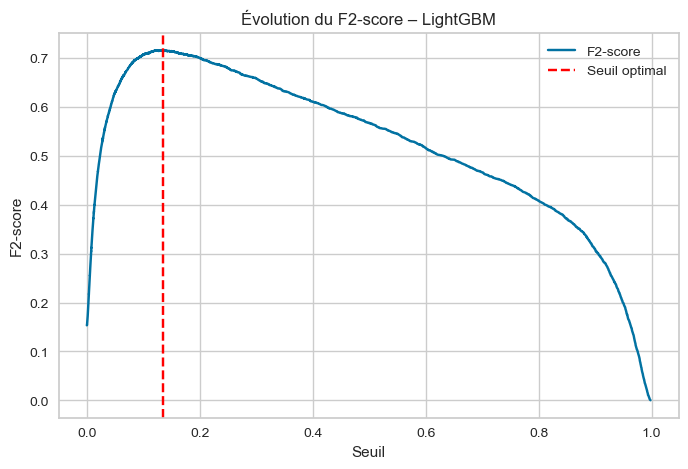

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds_lgb, f_beta_scores_lgb[:-1], label=f"F{beta}-score")
plt.axvline(x=best_threshold_lgb, color="red", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil")
plt.ylabel(f"F{beta}-score")
plt.title(f"Évolution du F{beta}-score – LightGBM")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Classification avec seuil optimal
y_pred_lgb_final = (y_prob_lgb >= best_threshold_lgb).astype(int)

# Résultats
print(" Évaluation finale – LightGBM (seuil optimal)")
report_with_fn(y_test, y_pred_lgb_final, beta=2)


 Évaluation finale – LightGBM (seuil optimal)
 Faux négatifs (fraudes non détectées) : 1058
              precision    recall  f1-score   support

           0     0.9907    0.9836    0.9871    113975
           1     0.6217    0.7440    0.6774      4133

    accuracy                         0.9752    118108
   macro avg     0.8062    0.8638    0.8322    118108
weighted avg     0.9777    0.9752    0.9763    118108

F2-score (β=2) : 0.7158


In [74]:
# Matrice de confusion
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb_final)
print("Matrice de confusion – LightGBM (seuil optimal):")
print(conf_matrix_lgb)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion – LightGBM (seuil optimal)")
plt.show()

# AUC score
auc_lgb = roc_auc_score(y_test, y_pred_lgb_final)
print(f"AUC – LightGBM (seuil optimal) : {auc_lgb:.4f}")

# Courbe ROC
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC – LightGBM')
plt.legend(loc="lower right")
plt.show()

AUC – Lightgbm : 0.8638


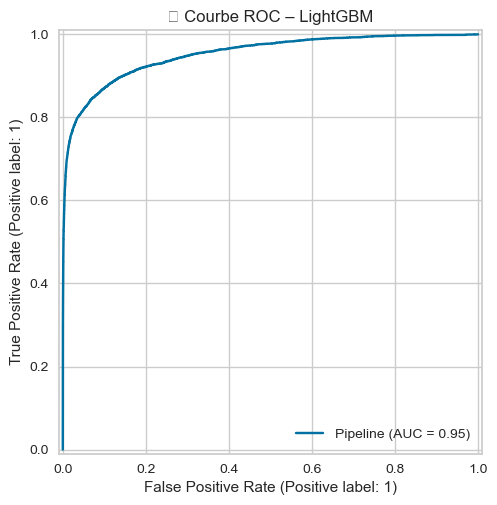

In [137]:
print("Best params:", grid_lgb.best_params_)

Best params: {'lgb__learning_rate': 0.1, 'lgb__max_depth': -1, 'lgb__n_estimators': 200, 'lgb__num_leaves': 64}


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 364721, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.260914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23010
[LightGBM] [Info] Number of data points in the train set: 820623, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223145
[LightGBM] [Info] Start training from score -0.223145
✅ Meilleurs paramètres SMOTE trouvés : {'smote__sampling_strategy': 0.8, 'smote__k_neighbors': 7}

📌 Seuil optimal avec SMOTE : 0.1898
🔹 F2-score optimal à ce seuil : 0.6593

📊 Évaluation finale – LightGBM avec SMOTE (seuil optimal)
 Faux négatifs (fraudes non détectées) : 1239
              precision    recall  f1-score   support

           0     0.9890    0.9779    0.9834

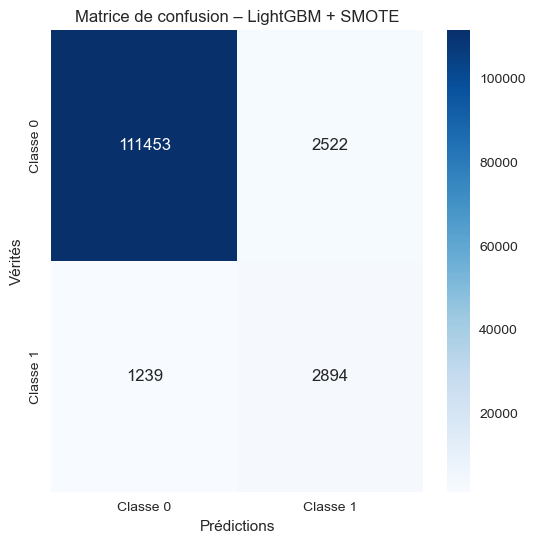

AUC – LightGBM avec SMOTE : 0.9353


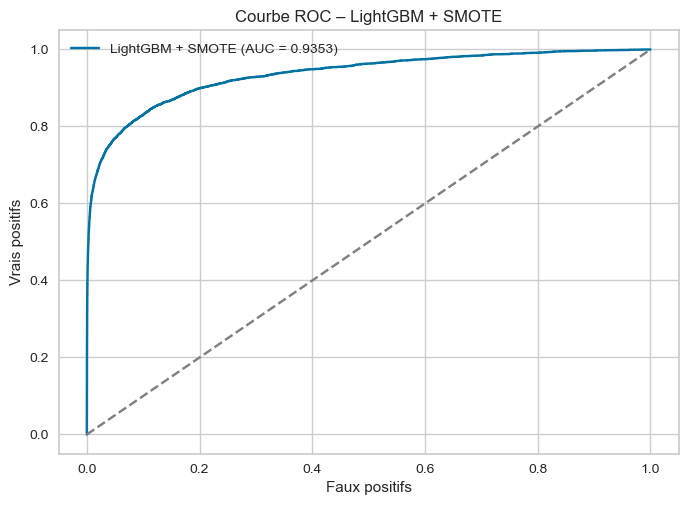

In [147]:
# ----------------------------
#  Importations nécessaires
# ----------------------------
from lightgbm import LGBMClassifier


# ----------------------------------------
# 1️ Pipeline LightGBM avec SMOTE (RF fixés)
# ----------------------------------------

# Meilleurs paramètres trouvés pour LightGBM

best_lgb_params = {
 "n_estimators": 200,
 "max_depth": -1,
 "learning_rate": 0.1,
 "num_leaves": 64
}

# Pipeline avec SMOTE + prétraitement + LightGBM
pipe_lgb_smote = ImbPipeline([
    ("preproc", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("lgb", LGBMClassifier(**best_lgb_params, random_state=42))
])

# -----------------------------------------
# 2️ Grille de recherche (SMOTE uniquement)
# -----------------------------------------
param_dist_smote_lgb = {
    "smote__k_neighbors": [3, 5, 7],
    "smote__sampling_strategy": [0.5, 0.8, 1.0]
}

# --------------------------------------------------
# 3️ RandomizedSearchCV (sur SMOTE uniquement)
# --------------------------------------------------
random_search_smote_lgb = RandomizedSearchCV(
    estimator=pipe_lgb_smote,
    param_distributions=param_dist_smote_lgb,
    n_iter=5,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# --------------------------
# 4️ Entraînement du modèle
# --------------------------
random_search_smote_lgb.fit(x_train, y_train)

best_lgb_smote_model = random_search_smote_lgb.best_estimator_
print(" Meilleurs paramètres SMOTE trouvés :", random_search_smote_lgb.best_params_)

# ------------------------------------------
# 5️ Prédiction proba + optimisation du seuil
# ------------------------------------------
y_prob_lgb_smote = best_lgb_smote_model.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_lgb_smote)

# F2-score
beta = 2
f2_scores = (1 + beta**2) * precision * recall / ((beta**2 * precision) + recall + 1e-6)

# Meilleur seuil
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

print(f"\n Seuil optimal avec SMOTE : {best_threshold:.4f}")
print(f" F{beta}-score optimal à ce seuil : {f2_scores[best_idx]:.4f}")

# ---------------------------
# 6️ Prédictions finales + évaluation
# ---------------------------
y_pred_lgb_final = (y_prob_lgb_smote >= best_threshold).astype(int)

print("\n Évaluation finale – LightGBM avec SMOTE (seuil optimal)")
report_with_fn(y_test, y_pred_lgb_final, beta=2)

# -----------------------------
# 7️ Matrice de confusion + ROC
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred_lgb_final)
print("Matrice de confusion – LightGBM avec SMOTE :")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion – LightGBM + SMOTE")
plt.show()

# AUC
auc_smote_lgb = roc_auc_score(y_test, y_prob_lgb_smote)
print(f"AUC – LightGBM avec SMOTE : {auc_smote_lgb:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lgb_smote)
plt.plot(fpr, tpr, label=f'LightGBM + SMOTE (AUC = {auc_smote_lgb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Faux positifs')
plt.ylabel('Vrais positifs')
plt.title('Courbe ROC – LightGBM + SMOTE')
plt.legend()
plt.show()


In [ ]:
!pip install joblib

In [ ]:
import os
import joblib

# Enregistrer le meilleur modele
joblib.dump(pipe_rf_smote, "4_models/random_forest_best_model.joblib")

# 2 MODELING